# UJM - Master DSC/MLDM - Deep Learning - TP1b - Images

## Objectives

In this practical session, we will deal with images and try to reproduce results on the famous MNIST Dataset

### Part 1 - MNIST basic

Getting MNIST

In [2]:
import numpy as np
np.random.seed(42)
import tensorflow
tensorflow.random.set_seed(42)

import keras
import time


from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('train data:\t', X_train.shape, y_train.shape)
print('test data:\t', X_test.shape, y_test.shape)

train data:	 (60000, 28, 28) (60000,)
test data:	 (10000, 28, 28) (10000,)


**Note** MNIST contains handwriting data of 10 numbers; each image has size 28 * 28. We display some examples below

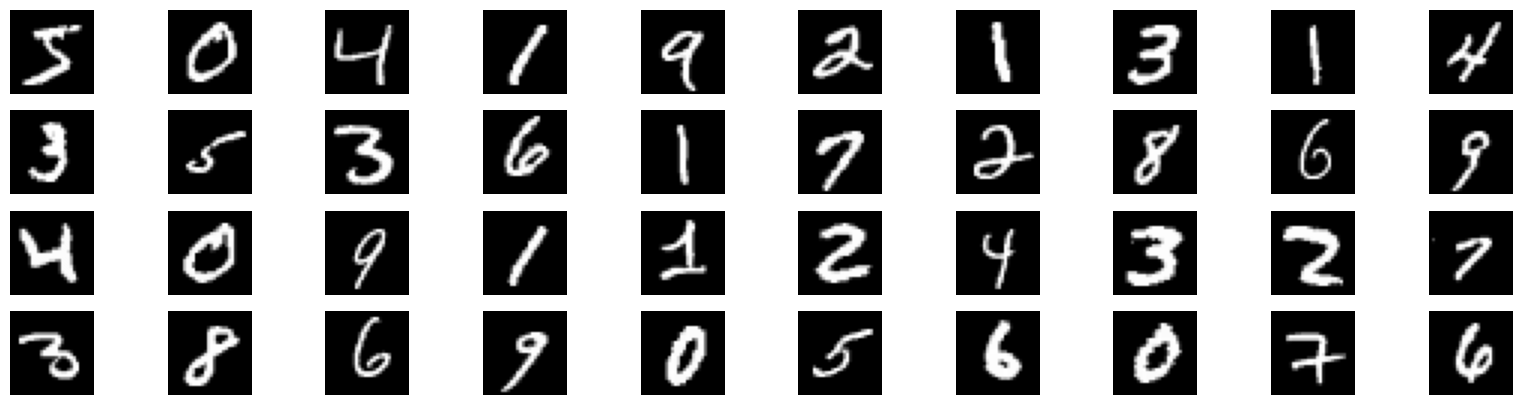

labels:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4, 10, i+1)
    example = X_train[i].reshape((28, 28))
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', y_train[:40])

**Note** We get keras modules and prepare data such that:
- normalize the data (so that the input $\in$ [0,1])
- reshape the input data so that:
- with `X_train` inputs are images: 28 x 28  matrices, adapted for convolutional NN,
- with `x_train` inputs are vectors of size 784, adapted for fully connected NN.  
- check the size of the inputs.

In [4]:
X_train = X_train/255
X_test = X_test/255

x_train = X_train.reshape(60000, 784)  # reshape input from (28,28) to 784
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(np.shape(X_train))
print(np.shape(x_train))

(60000, 28, 28)
(60000, 784)


We display 2 images

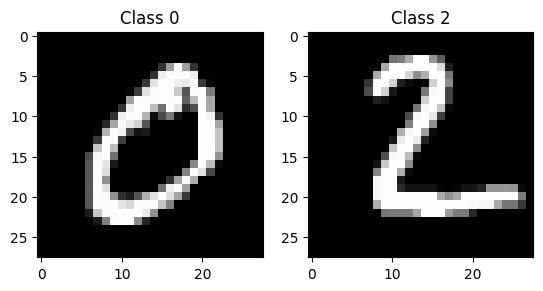

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(60000, 784), dtype=float32)

In [5]:
plt.subplot(1,2,1)
plt.imshow(X_train[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[1]))
plt.subplot(1,2,2)
plt.imshow(X_test[1], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_test[1]))
plt.show()

x_train.view()

**Note**
Data preprocessing: the output
-Now let's recode the output using a complete disjunctive coding in `Y_Train`. We have two ways of coding the outputs:
 - y_train a vector of 60 000 digits $\in$ {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
 - Y_Train a binary matrix of size 60 000 by 10

As in previous session, we take the second solution

In [6]:
num_classes = 10;
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

Y_train.view()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(60000, 10))

## Let's start with fully connected neural networks (NN)
They are also called multi layered perceptrons (MLP).

In that case, the sequential model of keras is used mainly because its more simple (for a discusion on the two keras modes see for instance https://jovianlin.io/keras-models-sequential-vs-functional/).

MLP have fully connected layers called `Dense` in Keras (https://keras.io/layers/core/).

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Input

### First try
Let's try to reproduce LeCun et al. 1998 reslts available on the [MNIST web site](http://yann.lecun.com/exdb/mnist/). With a 2-layer NN with 300 hidden units, the reported error rate is  4.7%.
We begin with creating the architecture of the NN.
- in that case the neural network is fully conected: the NN is sequential,
- the first layer contained 300 neurons with `tanh` as an activation function,
- the output layer contain 10 neurones (one per class) and the activation function is the `softmax`.

In [9]:
NN = Sequential()
NN.add(Input(shape=(784,)))
NN.add(Dense(units=300, activation='tanh'))
NN.add(Dense(units=10, activation='softmax'))
NN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,510 (931.68 KB)

 Trainable params: 238,510 (931.68 KB)

 Non-trainable params: 0 (0.00 B)

**Next step**
Now we are going to train the NN.  
The first step here is to define the cost funtion (the loss) and the learning algorithm.
A natural choice for the loss is the `categorical_crossentropy` well suited for multiclass classification.
As a learning algorithm, let's began with the simple stochastic gradient descent optimizer, with default parameter initialization (that is a learning rate set at $0.01$).   
The second step consist in fitting the NN to the data.
By setting the `verbose` parameter to 0 (no outputs during training), the computing time is significantly reduced.
This training phase may take about one minute.

In [10]:
NN.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(),
           metrics   = ['accuracy'])
t0=time.time()
NN.fit(x_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))


total computing time: 117.02611565589905


**Next** The quality of this NN is determined by measuring its error rate on the test set.

In [11]:
score = NN.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9396 - loss: 0.2118
Test loss: 0.212 
Test err:  6.04 %


**Question** Try to retrain the same model but by replacing the 'tanh' activation by a 'relu' activation, what happens?

In [12]:
NN = Sequential()
NN.add(Input(shape=(784,)))
NN.add(Dense(units=300, activation='relu'))
NN.add(Dense(units=10, activation='softmax'))
NN.summary()


NN.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(),
           metrics   = ['accuracy'])
t0=time.time()
NN.fit(x_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))



score = NN.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,510 (931.68 KB)

 Trainable params: 238,510 (931.68 KB)

 Non-trainable params: 0 (0.00 B)


total computing time: 131.44615983963013
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9561 - loss: 0.1520
Test loss: 0.152 
Test err:  4.39 %


### Second try
Ok, let's improve our training a little bit by introduicing some punch in our optimizer.
To do so we add a momentum term (`momentum=0.9`) and some L2 penalty (`decay=1e-6`). This is done by  replacing the instruction `optimizer=keras.optimizers.SGD(),`  by  `optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), `
 and resume training in the same way as we just did (it may take about one minute).

 If you are using a new version of keras, the argument decay has been deprecated. To simulate the behavior of decay, we need to stablish a learning schedule.

In [13]:
import tensorflow as tf
initial_learning_rate = 0.01
old_decay = 1e-6
steps_per_epoch = 60000 // 32  # 1875 steps per epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1,
    decay_rate=1 - old_decay,
    staircase=False
)

In [14]:
NN1 = Sequential()
NN1.add(Input(shape=(784,)))
NN1.add(Dense(units=300, activation='tanh'))
NN1.add(Dense(units=10, activation='softmax'))
NN1.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),
            metrics=['accuracy'])

**Next** We evaluate

In [15]:
t0=time.time()
NN1.fit(x_train, Y_train, epochs=10, verbose=0) # The batch_size argument for the fit method is 32 by default
print('')
print('total computing time: '+str(time.time()-t0))

score = NN1.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 103.15339279174805
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9776 - loss: 0.0703
Test loss: 0.070 
Test err:  2.24 %


### Third try

Let's try the same architecture with another optimizer.
Try the `Adadelta` optimizer with default parameters(it may take about one minute).  
To do so, replace the instruction  `optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),` by  `optimizer=keras.optimizers.Adadelta(), `

We retrain the model and evaluate

In [16]:
NN2 = Sequential()
NN2.add(Input(shape=(784,)))
NN2.add(Dense(units=300, activation='tanh'))
NN2.add(Dense(units=10, activation='softmax'))
NN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
t0=time.time()
NN2.fit(x_train, Y_train, epochs=20, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN2.evaluate(x_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 223.1776900291443
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8854 - loss: 0.4738
Test loss: 0.474 
Test err:  11.46 %


### Fourth try

In the MNIST leaderboad, with a 3-layer NN, 500+300 HU, softmax, cross entropy, weight decay, Hinton, reproted in 2005 an error rate of 1.53%. For fun we can use a ReLU activation function. The training phase takes about 5 minutes.

We retrain and evaluate

In [17]:
NN3 = Sequential()
NN3.add(Input(shape=(784,)))
NN3.add(Dense(units=500, activation='relu'))
NN3.add(Dense(units=300, activation='tanh'))
NN3.add(Dense(units=10, activation='softmax'))

NN3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

NN3.summary()

t0=time.time()
NN3.fit(x_train, Y_train, epochs=20, verbose = 0,batch_size=64)
print('')
print('total computing time: '+str(time.time()-t0))

score = NN3.evaluate(x_test, Y_test, verbose=0)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,810 (2.08 MB)

 Trainable params: 545,810 (2.08 MB)

 Non-trainable params: 0 (0.00 B)


total computing time: 272.71758556365967
Test loss: 0.113 
Test err:  1.98 %


## Let's continue with Convolutional neural networks (CNN)

In the MNIST leaderboad, LeCun et al. 1998 reported with LeNet-5 an error rate of 0.95%.
LeNet-5 is a convolutional neural network.

<img src="https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-11.34.51-AM.png" alt="MNIST data" width="360" height="270" border="5" />

Convolution used to process images are 2d convolutions taking tensors as input and output.
To fit into the first 2d convolutional layer, the input have to be recast as tensor of dimension $28 \times 28 \times 1$. This can be performed by using a reshape.

In [18]:
img_rows, img_cols = 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train.shape

(60000, 28, 28, 1)

## First try with CNN
With a simplified version of LeNet-5 and with ReLU instead of hyperbolic tangent as activation function. It takes about 3 minutes.


In [19]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

CNN = Sequential()
CNN.add(Input(shape=(28,28,1)))
CNN.add(Conv2D(6, kernel_size=(5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(16, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
CNN.add(Dense(120, activation='relu'))
CNN.add(Dense(84, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 95.73714423179626
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9873 - loss: 0.0617
Test loss: 0.062 
Test err:  1.27 %


## Second try
With a CNN slightly more complex

In [20]:
CNN = Sequential()
CNN.add(Input(shape=(28,28,1)))
CNN.add(Conv2D(32, kernel_size=(5, 5),
           activation='relu'))
CNN.add(Conv2D(64, (3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.25))
CNN.add(Flatten())
CNN.add(Dense(128, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(10, activation='softmax'))
CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
CNN.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,978 (3.86 MB)

 Trainable params: 1,011,978 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

**Next** we proceed to the training in the same way, using `Adam` as optimizer. It may take about 15 minutes.

In [21]:
t0=time.time()
CNN.fit(X_train, Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = CNN.evaluate(X_test, Y_test)
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 751.0619926452637
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9929 - loss: 0.0281
Test loss: 0.028 
Test err:  0.71 %


**Question** Can you improve these results by using other activation functions (e.g. 'relu')?

In [22]:
# Tanh CNN in Keras (mirroring the PyTorch experiment)

CNN_tanh = Sequential()
CNN_tanh.add(Input(shape=(28,28,1)))

CNN_tanh.add(Conv2D(32, kernel_size=(5,5), activation='tanh'))
CNN_tanh.add(Conv2D(64, kernel_size=(3,3), activation='tanh'))
CNN_tanh.add(MaxPooling2D(pool_size=(2,2)))
CNN_tanh.add(Dropout(0.25))

CNN_tanh.add(Flatten())
CNN_tanh.add(Dense(128, activation='tanh'))
CNN_tanh.add(Dropout(0.5))
CNN_tanh.add(Dense(10, activation='softmax'))

CNN_tanh.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

t0 = time.time()
CNN_tanh.fit(X_train, Y_train, epochs=10, verbose=0)
print(f"\nTotal training time: {time.time()-t0:.2f} seconds")

score = CNN_tanh.evaluate(X_test, Y_test, verbose=0)
err = 100*(1-np.array(score))
print("Tanh CNN Test loss: %4.3f" % score[0])
print("Tanh CNN Test err:  %4.2f%%" % err[1])


Total training time: 806.79 seconds
Tanh CNN Test loss: 0.052
Tanh CNN Test err:  1.62%


**Question** Can you improve the results above with more complex architectures?

In [25]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Dense, Input, ReLU

CNN_deep = Sequential([
    Input(shape=(28,28,1)),

    Conv2D(32, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(32, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2),
    Dropout(0.25),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2),
    Dropout(0.25),

    Flatten(),
    Dense(128),
    ReLU(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

CNN_deep.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

CNN_deep.fit(X_train, Y_train, epochs=5, batch_size=64, verbose=0)
score = CNN_deep.evaluate(X_test, Y_test, verbose=0)
err = 100*(1-np.array(score))
print("Deep CNN test err: %.2f%%" % err[1])


Deep CNN test err: 1.32%


# Part 3 Other dataset

try to do your best with another version of this dataset: fashion_MNIST

train data:	 (60000, 28, 28) (60000,)
test data:	 (10000, 28, 28) (10000,)


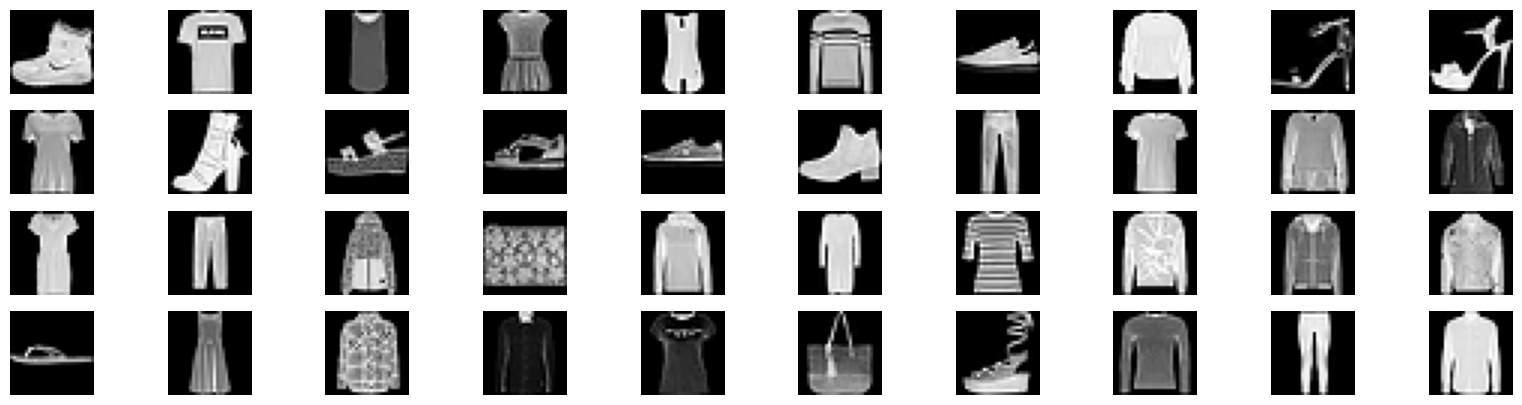

labels:  [9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6]


In [26]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print('train data:\t', X_train.shape, y_train.shape)
print('test data:\t', X_test.shape, y_test.shape)

plt.figure(figsize=(20,5))
for i in range(40):
    plt.subplot(4, 10, i+1)
    example = X_train[i].reshape((28, 28))
    plt.imshow(example, cmap = 'gray')
    plt.axis('off')
plt.show()
print('labels: ', y_train[:40])

**Note** Try classic MLP and convolutional Neural Networks of different complexities, different regularizers, ...


In [29]:
x_train_fashion = X_train.reshape(X_train.shape[0], 28 * 28).astype('float32') / 255
x_test_fashion = X_test.reshape(X_test.shape[0], 28 * 28).astype('float32') / 255
Y_train_fashion = keras.utils.to_categorical(y_train, num_classes)
Y_test_fashion = keras.utils.to_categorical(y_test, num_classes)

# Simple MLP model
MLP_fashion = Sequential()
MLP_fashion.add(Input(shape=(784,)))
MLP_fashion.add(Dense(units=128, activation='relu'))
MLP_fashion.add(Dense(units=10, activation='softmax'))

MLP_fashion.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

MLP_fashion.summary()

t0 = time.time()
MLP_fashion.fit(x_train_fashion, Y_train_fashion, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))

score = MLP_fashion.evaluate(x_test_fashion, Y_test_fashion)
err = 100 * (1 - np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)


total computing time: 98.36102938652039
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8760 - loss: 0.3635
Test loss: 0.364 
Test err:  12.40 %


In [30]:
# basic CNN model

CNN = Sequential()

# Input: 28x28x1 same as PyTorch
CNN.add(Input(shape=(28,28,1)))

CNN.add(Conv2D(6, kernel_size=5, activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))

CNN.add(Conv2D(16, kernel_size=5, activation='relu'))
CNN.add(MaxPooling2D(pool_size=2))

CNN.add(Flatten())
CNN.add(Dense(120, activation='relu'))
CNN.add(Dense(84, activation='relu'))
CNN.add(Dense(10, activation='softmax'))

CNN.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

CNN.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=0)

score = CNN.evaluate(X_test, Y_test, verbose=0)
err = 100 * (1 - score[1])

print("CNN Test loss: %4.3f" % score[0])
print("CNN Test err:  %4.2f%%" % err)



CNN Test loss: 2.342
CNN Test err:  89.43%


**Note** you could compare your results with:  <https://www.kaggle.com/pavansanagapati/fashion-mnist-cnn-model-with-tensorflow-keras>

**Final Question** Write down the similarities and differences between torch and keras version of the notebooks below.


Both frameworks solved the same tasks: MLPs and CNNs on MNIST, Fashion-MNIST, and CIFAR-10. Training behavior, accuracy trends, and dataset difficulty matched: MLPs plateaued on images, deeper CNNs jumped to high accuracy, Fashion-MNIST was harder than MNIST, and CIFAR-10 needed deeper conv stacks to perform well. The learning curves and optimizer effects aligned across both; Adam accelerated convergence, momentum helped SGD, tanh slowed learning, and ReLU consistently won. The architectural changes produced comparable performance shifts in each environment, confirming the designs rather than the libraries drive the outcomes.

The workflows differed. PyTorch used manual training loops and explicit gradient steps, while Keras hid much of this under `fit()` and `compile()`. PyTorch expected raw logits before cross-entropy; Keras applied softmax at the output. Data pipelines also varied: PyTorch relied on `DataLoader` and torchvision transforms; Keras reshaped and fed arrays directly. PyTorch offered more granular control and transparency; Keras delivered faster prototyping with cleaner high-level abstractions. In both cases, core deep-learning principles held, and results stayed consistent once the activation, loss, and optimizer configurations were aligned.